In [1]:
import cv2 as cv
import math
import numpy as np
import sem_utils
import os
import logging
import time
import pickle
import skimage.draw
import sys

from itertools import combinations
from matplotlib import pyplot as plt
from matplotlib import patches
from plot_scale_determine import PlotScaleDetermine
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from mrcnn import utils
from mrcnn import visualize

sys.path.append('/home/zeng/Mask_RCN')
psd = PlotScaleDetermine()
# log setting
logging.basicConfig(format='%(levelname)s: %(funcName)s, %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
def dis(w, h):
    return math.sqrt(w**2+h**2)

def find_largest_mbr(contours):
    res = []
    for cnt in contours:
        # rect: ((x, y), (length, width), rotate_angle)
        rect = cv.minAreaRect(cnt)
        res.append(rect)
    # sort by digonal line length to get largest box
    if res == []:
        return (None, None), (None, None), None
    res = sorted(res, key=lambda x: dis(*x[1]), reverse=True)
    return res[0]

def get_mbr(_img_mask):
    _img_mask = np.array(_img_mask, dtype=np.uint8)
    _, contours, _ = cv.findContours(_img_mask, 1, 2)
    (x, y), (length_1, length_2), rotate_angle = find_largest_mbr(contours)

    box = cv.boxPoints(((x, y), (length_1, length_2), rotate_angle))
    box = np.int0(box)

    # box[1] is the coordinate of lower left x and y
    return box[1], length_1, length_2, rotate_angle

In [3]:
class SemImage(object):

    def __init__(self, img_path, psd_model=None):
        """
        $para:
            rois: [N, (y1, x1, y2, x2)] detection bounding boxes
            masks: [H, W, N] instance binary masks
        """
        self.img_path = img_path
        self.img_gray = cv.imread(img_path, 0)
        self.img_color = skimage.io.imread(img_path)
        
        # get length_per_pixel, length_of_scale_bar
        psd = PlotScaleDetermine() if not psd_model else psd_model
        self.l_p_p, self.l_o_s_b = psd.determine(img_path)
        self.rois, self.masks, self.class_ids, self.scores = sem_utils.read_npz(img_path)
        self.img_rois, self.img_masks, self.img_masks_cut, self.mbrs = [], [], [], []
        self.length, self.thickness = [], []
        
        # get image by rois/masks
        for i in range(self.scores.shape[0]):
            x1, y1, x2, y2 = self.rois[i]
            self.img_rois.append(self.img_gray[x1:x2, y1:y2])
            self.img_masks.append(self.masks[x1:x2, y1:y2, i])
            self.img_masks_cut.append(np.multiply(self.img_rois[-1], self.img_masks[-1]))
            self.mbrs.append(get_mbr(self.img_masks[-1]))
            # convert size into nanometer
            self.length.append(max(self.mbrs[-1][1:3]) * self.l_p_p)
            self.thickness.append(min(self.mbrs[-1][1:3]) * self.l_p_p)
        
        
        logging.info('image path: {}'.format(img_path))
        logging.info('\nimage resolution: {}'.format(self.img_gray.shape))
        logging.info('length_per_pixel: {:>5.2f} nm\tscale_bar: {:>5.2f} nm'\
                     .format(self.l_p_p, self.l_o_s_b))
        
    def plot_detect_result(self):
        visualize.display_instances(self.img_color, self.rois, self.masks, 
                                    self.class_ids, ['BG', 'mol'], self.scores, 
                                    title=self.img_path, figsize=(8, 8))
        
    def plot_measuer_result(self):
        fig, ax = plt.subplots(self.scores.shape[0], 4)
        if len(ax.shape) == 1:
            ax = [ax]
        
        ax[0][0].set_title('roi')
        ax[0][1].set_title('mask')
        ax[0][2].set_title('mask cut')
        ax[0][3].set_title('mbr')
        
        for measure_index in range(self.scores.shape[0]):
            # taggle axis off
            for i in range(4):
                ax[measure_index][i].set_xticks([])
                ax[measure_index][i].set_yticks([])
        
            ax[measure_index][0].imshow(sm.img_rois[measure_index], cmap ='gray')
            
            ax[measure_index][1].imshow(sm.img_masks[measure_index], cmap ='gray')
            
            ax[measure_index][2].imshow(sm.img_masks_cut[measure_index], cmap ='gray')
            
            ax[measure_index][3].imshow(sm.img_masks[measure_index], cmap ='gray')
            
            xy, length_1, length_2, rotate_angle = sm.mbrs[measure_index]
            mbr_patch = patches.Rectangle(xy, length_1, length_2, rotate_angle, 
                                          linewidth=2, fill=False, color='white')
            ax[measure_index][3].add_patch(mbr_patch)
            
            logging.info('#{} Mask occupation: {:.2f}, length: {:>4.1f}nm, thickness: {:>4.1f}nm'\
                         .format(measure_index, np.sum(sm.img_masks[measure_index])/length_1/length_2, 
                                 sm.length[measure_index], sm.thickness[measure_index]))

INFO: __init__, image path: /home/zeng/Mask_RCNN/datasets/mol/val/38-32-bpdc001.jpg
INFO: __init__, 
image resolution: (768, 1024)
INFO: __init__, length_per_pixel:  3.57 nm	scale_bar: 200.00 nm


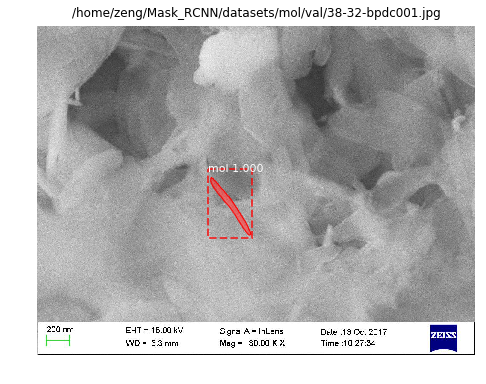

INFO: plot_measuer_result, #0 Mask occupation: 0.73, length: 576.0nm, thickness: 58.8nm


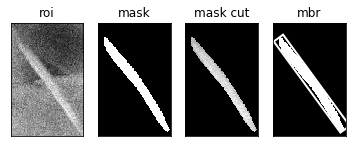

In [4]:
image_path = '/home/zeng/Mask_RCNN/datasets/mol/val/38-32-bpdc001.jpg'
sm = SemImage(image_path, psd)
sm.plot_detect_result()
sm.plot_measuer_result()

In [5]:
# taggle axis off
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[0].imshow(sm.img_rois[0], cmap ='gray')
ax[0].set_title('roi')
ax[1].imshow(sm.img_masks[0], cmap ='gray')
ax[1].set_title('mask')
ax[2].imshow(sm.img_masks_cut[0], cmap ='gray')
ax[2].set_title('mask cut')
ax[3].imshow(sm.img_masks[0], cmap ='gray')
ax[3].set_title('mbr')
xy, length_1, length_2, rotate_angle = sm.mbrs[0]
mbr_patch = patches.Rectangle(xy, length_1, length_2, rotate_angle, 
                              linewidth=2, fill=False, color='white')
ax[3].add_patch(mbr_patch)
logging.info('Mask occupation: {:.2f}, length: {:>6.1f}nm, thickness: {:>6.1f}nm'\
             .format(np.sum(sm.img_masks[0])/length_1/length_2, 
                     sm.length[0], sm.thickness[0]))

NameError: name 'ax' is not defined